In [62]:
'''
Created on Feb 16, 2011
k Means Clustering for Ch10 of Machine Learning in Action
@author: Peter Harrington
'''
from numpy import *

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = map(float,curLine) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat

def distEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2))) #la.norm(vecA-vecB)

def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k,n)))#create centroid mat
    for j in range(n):#create random cluster centers, within bounds of each dimension
        minJ = min(dataSet[:,j]) 
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = mat(minJ + rangeJ * random.rand(k,1))
    return centroids
    
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))#create mat to assign data points 
                                      #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):#for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        print centroids
        for cent in range(k):#recalculate centroids
            ptsInClust = dataSet[nonzero(clusterAssment[:,0].A==cent)[0]]#get all the point in this cluster
            centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean 
    return centroids, clusterAssment

def biKmeans(dataSet, k, distMeas=distEclud):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #create a list with one centroid
    for j in range(m):#calc initial Error
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:]#get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1])#compare the SSE to the currrent minimum
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            print "sseSplit, and notSplit: ",sseSplit,sseNotSplit
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        print 'the bestCentToSplit is: ',bestCentToSplit
        print 'the len of bestClustAss is: ', len(bestClustAss)
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]#replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss#reassign new clusters, and SSE
    return mat(centList), clusterAssment

import urllib
import json
def geoGrab(stAddress, city):
    apiStem = 'http://where.yahooapis.com/geocode?'  #create a dict and constants for the goecoder
    params = {}
    params['flags'] = 'J'#JSON return type
    params['appid'] = 'aaa0VN6k'
    params['location'] = '%s %s' % (stAddress, city)
    url_params = urllib.urlencode(params)
    yahooApi = apiStem + url_params      #print url_params
    print yahooApi
    c=urllib.urlopen(yahooApi)
    return json.loads(c.read())

from time import sleep
def massPlaceFind(fileName):
    fw = open('places.txt', 'w')
    for line in open(fileName).readlines():
        line = line.strip()
        lineArr = line.split('\t')
        retDict = geoGrab(lineArr[1], lineArr[2])
        if retDict['ResultSet']['Error'] == 0:
            lat = float(retDict['ResultSet']['Results'][0]['latitude'])
            lng = float(retDict['ResultSet']['Results'][0]['longitude'])
            print "%s\t%f\t%f" % (lineArr[0], lat, lng)
            fw.write('%s\t%f\t%f\n' % (line, lat, lng))
        else: print "error fetching"
        sleep(1)
    fw.close()
    
def distSLC(vecA, vecB):#Spherical Law of Cosines
    a = sin(vecA[0,1]*pi/180) * sin(vecB[0,1]*pi/180)
    b = cos(vecA[0,1]*pi/180) * cos(vecB[0,1]*pi/180) * \
                      cos(pi * (vecB[0,0]-vecA[0,0]) /180)
    return arccos(a + b)*6371.0 #pi is imported with numpy

import matplotlib
import matplotlib.pyplot as plt
def clusterClubs(numClust=5):
    datList = []
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = mat(datList)
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)
    fig = plt.figure()
    rect=[0.1,0.1,0.8,0.8]
    scatterMarkers=['s', 'o', '^', '8', 'p','d', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0=fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP)
    ax1=fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[nonzero(clustAssing[:,0].A==i)[0],:]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0], marker=markerStyle, s=90)
    ax1.scatter(myCentroids[:,0].flatten().A[0], myCentroids[:,1].flatten().A[0], marker='+', s=300)
    plt.show()


[[  1.07285963e+00  -1.82884309e+00]
 [  4.34655229e+00  -9.81855725e-01]
 [ -7.29120169e-04  -1.64975090e+00]
 [ -3.75294571e+00   4.39903638e-01]]
[[ 0.6900742  -3.3669896 ]
 [ 3.1222835   3.1029245 ]
 [-0.59807788 -1.88384988]
 [-2.94737575  3.3263781 ]]
[[ 0.35496167 -3.36033556]
 [ 2.93386365  3.12782785]
 [-1.12616164 -2.30193564]
 [-2.94737575  3.3263781 ]]


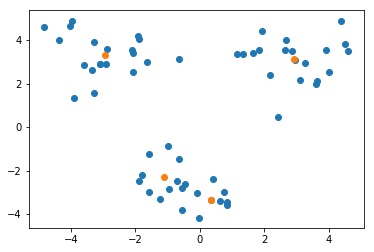

In [64]:
X = loadDataSet("testSet2.txt")
X = mat(X)
CT, CA = kMeans(X, 4)
plt.scatter(X[:,0].flatten().A[0], X[:,1].flatten().A[0])
plt.scatter(CT[:,0].flatten().A[0], CT[:,1].flatten().A[0])
plt.show()

In [88]:
def loadData(name):
    X = []
    y = []
    f = open(name)
    for x in f.readlines():
        x = x.strip().split('\t')
        X.append(map(float, x))
        y.append(x[-1])
    return array(X), array(y)

def randCent(X,k):
    n = X.shape[1]
    CT = zeros((k,n))
    for j in xrange(n):
        r = float(X[:,j].max() - X[:,j].min())
        CT[:,j] = X[:,j].min() + r * random.rand(k)
    return CT

def kMeans(X, k):
    m = X.shape[0]
    CA = zeros(X.shape)
    CT = randCent(X, k)
    flag = True
    while flag:
        flag = False
        for i in xrange(m):
            md = inf
            mi = -1
            for j in xrange(k):
                dij = sqrt(sum((X[i,:] - CT[j,:])**2))
                if dij < md:
                    md = dij
                    mi = j
            if CA[i,0] != mi:
                flag = True
            CA[i,:] = [mi, md**2]
        for c in xrange(k):
            XX = X[CA[:,0] == c]
            CT[c, :] = mean(XX, axis=0)
    return CT, CA

[[-0.45965615 -2.7782156 ]
 [ 2.93386365  3.12782785]
 [        nan         nan]
 [-2.94737575  3.3263781 ]]
[[  1.00000000e+00   1.45461050e-01]
 [  3.00000000e+00   6.80213825e-01]
 [  0.00000000e+00   1.02184582e+00]
 [  1.00000000e+00   1.34548760e+00]
 [  3.00000000e+00   1.35376464e+00]
 [  0.00000000e+00   3.87167519e+00]
 [  1.00000000e+00   8.37259951e-01]
 [  3.00000000e+00   2.20116272e-01]
 [  0.00000000e+00   3.53809057e+00]
 [  1.00000000e+00   7.44081160e+00]
 [  3.00000000e+00   5.28070040e+00]
 [  0.00000000e+00   2.56674394e-02]
 [  1.00000000e+00   1.11946529e+00]
 [  3.00000000e+00   1.67890884e-01]
 [  0.00000000e+00   2.11734245e+00]
 [  1.00000000e+00   1.49635209e+00]
 [  3.00000000e+00   4.93628241e+00]
 [  0.00000000e+00   9.76749869e-03]
 [  1.00000000e+00   1.32453845e-01]
 [  3.00000000e+00   6.39346045e-01]
 [  0.00000000e+00   9.41791924e-01]
 [  1.00000000e+00   1.72445523e+00]
 [  3.00000000e+00   7.50682798e-01]
 [  0.00000000e+00   1.48785604e-01]
 [ 

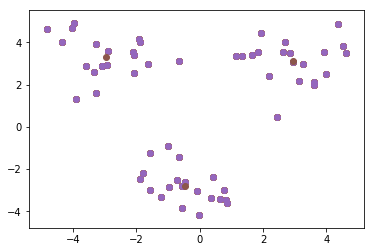

In [89]:
X, y = loadData("testSet2.txt")
CT, CA = kMeans(X, 4)
plt.scatter(X[:,0], X[:,1])
plt.scatter(CT[:,0], CT[:,1])
plt.show()

In [159]:
def biKmeans(X, k):
    m = X.shape[0]
    CA = zeros(X.shape)
    c0 = mean(X, axis=0)
    CT = []
    CT.append(map(float, c0))
    for i in xrange(m):
        CA[i,:] = [0,sqrt(sum((X[i,:] - c0) ** 2))]
    while len(CT) < k:
        SSE = inf
        bi = -1
        for i in xrange(len(CT)):
            XX = X[CA[:,0] == i]
            TCT, TCA = kMeans(XX, 2)
            sp = sum(TCA[:,1])
            nsp = sum(CA[CA[:,0] != i, 1])
            print "sp, nsp", sp, nsp
            if (sp + nsp) < SSE:
                bi = i
                bCT = TCT.copy()
                bCA = TCA.copy()
                SSE = sp + nsp
        bCA[bCA[:,0] == 0, 0] = bi
        bCA[bCA[:,0] == 1, 0] = len(CT)
        print "bi", bi
        print "len", len(bCA)
        CT[bi] = map(float, bCT[0,:])
        CT.append(map(float, bCT[1,:]))
        CA[CA[:,0] == bi, :] = bCA
    return CT, CA

sp, nsp 453.033489581 0.0
bi 0
len 60
sp, nsp 12.7532631369 423.876240137
sp, nsp 77.5922493178 29.1572494441
bi 1
len 40


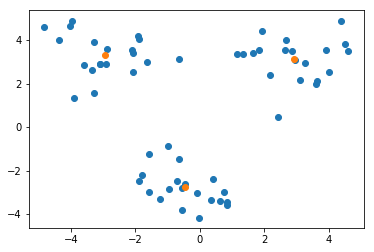

In [160]:
X, y = loadData("testSet2.txt")
CT, CA = biKmeans(X, 3)
plt.scatter(X[:,0], X[:,1])
CT = array(CT)
plt.scatter(CT[:,0], CT[:,1])
plt.show()